# 🎰 ML Walkthrough (Recommender + FTD Propensity) for iGaming Affiliates

This notebook demonstrates a **contextual ranking system** designed to maximize revenue (EPC) by optimally matching Affiliates to Brands/Operators. This system moves beyond simple historical performance by blending long-term affiliate affinity with short-term, context-specific conversion probability.

### **The Business Goal**
To answer the question: ***"For a given affiliate, geo, and device, which brand will generate the highest expected revenue per click (EPC) right now?"***

### **Technical Implementation**
1. Loads synthetic demo data (`affiliates.csv`, `brands.csv`, `events.csv`).
2. Builds an **SVD-based Collaborative Filter** on historical performance (Affiliate × Brand affinity).
3. Trains a **Random Forest Classifier** to predict **First-Time Deposit (FTD) Propensity** based on real-time context (Geo, Device, Time of Day).
4. Blends both models with brand economic data to generate a **contextual ranking** based on **Expected EPC**.

**Files in this folder:** `affiliates.csv`, `brands.csv`, `events.csv`, `README.md`.

Run the cells sequentially. If packages are missing, run the pip install cell below first.


## Prerequisites

If you don't have the libraries installed, run the following (uncomment and run):

In [1]:
#!pip install pandas

In [2]:
# !pip install pandas numpy scikit-learn scipy nbformat matplotlib
# Uncomment and run if needed

## 1) Imports and Data Loading 💾

We import all necessary libraries for data manipulation (`pandas`, `numpy`), machine learning (`sklearn`, `scipy`), and visualization (`matplotlib`, `seaborn`).


In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime, timedelta

# ML
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# reproducibility
RANDOM_STATE = 42

DATA_DIR = Path(r'C:\Users\karlc\OneDrive - Karl Cini\Synerf\Marketing\Github projects\Recommender System - Gaming')
print('Data dir:', DATA_DIR)
print('Files available:')
for p in DATA_DIR.glob('*'):
    print('-', p.name)

    


Data dir: C:\Users\karlc\OneDrive - Karl Cini\Synerf\Marketing\Github projects\Recommender System - Gaming
Files available:
- .ipynb_checkpoints
- affiliates.csv
- brands.csv
- events.csv
- README.md
- recommender_system_demo.ipynb
- recommender_system_with_notes.ipynb


## 2) Load the demo CSV files

We load the three core datasets:
- `affiliates.csv`: Static profile data on affiliates (e.g., GEO focus, Quality Score).
- `brands.csv`: Static profile and economic data on brands (e.g., Payout Type, Baselines).
- `events.csv`: Historical daily performance data (Clicks, Registrations, FTDs, NGR).


In [4]:
affiliates = pd.read_csv(DATA_DIR / 'affiliates.csv')
brands = pd.read_csv(DATA_DIR / 'brands.csv')
events = pd.read_csv(DATA_DIR / 'events.csv', parse_dates=['date'])

print('affiliates:', affiliates.shape)
print('brands:', brands.shape)
print('events:', events.shape)

# show a few rows
affiliates.head()


affiliates: (200, 5)
brands: (50, 8)
events: (356229, 11)


,affiliate_id,primary_geo,traffic_source,vertical_focus,avg_quality
0,1,SE,Social,Sports,0.665945
1,2,FR,Messaging,Poker,0.678628
2,3,ES,Social,Casino,0.641441
3,4,NZ,Streaming,Casino,0.388085
4,5,CA,Social,Casino,0.253484


In [5]:
brands.head()

,brand_id,brand_name,vertical,payout_type,baseline_cr,baseline_ftd,avg_ftd_value,allowed_geos
0,1,Brand_01,Casino,CPA,0.049551,0.258553,144.385910,"['BR', 'FR', 'CA', 'NZ', 'PT', 'RO', 'DK']"
1,2,Brand_02,Casino,Hybrid,0.016751,0.363391,237.805206,"['NZ', 'PT', 'DK', 'ES', 'RO', 'SE', 'DE']"
2,3,Brand_03,Casino,CPA,0.025758,0.300299,84.907374,"['SE', 'FR', 'PT', 'IT', 'FI', 'DK', 'NL']"
3,4,Brand_04,Casino,RevShare,0.067411,0.334021,198.880583,"['FI', 'DE', 'PL', 'NL', 'IT']"
4,5,Brand_05,Casino,CPA,0.030319,0.367008,145.993697,"['BR', 'FR', 'SE', 'PT', 'IT']"


In [6]:
events.head()

,date,affiliate_id,brand_id,geo,device,clicks,registrations,ftds,ngr,campaign_id,traffic_source
0,2025-03-11,11,16,SE,android,19,1,0,0.000000,1099,PPC
1,2025-03-11,74,4,SE,android,14,1,1,144.539659,1059,Messaging
2,2025-03-11,135,21,FR,desktop,16,0,0,0.000000,1079,Social
3,2025-03-11,153,24,IT,desktop,18,1,0,0.000000,1085,PPC
4,2025-03-11,71,38,CA,desktop,23,0,0,0.000000,1026,PPC


In [7]:
events.date.min(), events.date.max()

(Timestamp('2025-03-11 00:00:00'), Timestamp('2025-09-06 00:00:00'))

## 3) Build SVD Recommender (Collaborative Filtering) 🤝

The goal of this section is to measure the **historical affinity** between every Affiliate and every Brand, allowing us to recommend a new Brand based on the success of *similar* Affiliates. This is a crucial component for long-term relevance.

### **3.1) Prepare Interaction Matrix**
We use an implicit interaction score `score = FTDs + 0.005 * NGR` as the signal for affinity between an affiliate and a brand. This score emphasizes FTDs (the core metric) but rewards Net Gaming Revenue (NGR) performance as a quality indicator. We then train TruncatedSVD on the resulting Affiliate × Brand sparse matrix.


In [8]:
# Train/test split by time: last 30 days as test
cutoff = events['date'].max() - pd.Timedelta(days=30)
train_events = events[events['date'] <= cutoff].copy()
test_events = events[events['date'] > cutoff].copy()

print('train days up to', cutoff.date(), ', train rows:', train_events.shape[0])
print('test days from' , (cutoff.date() + pd.Timedelta(days=1)), 'up to', events.date.max().date(), ', test rows:', test_events.shape[0])


train days up to 2025-08-07 , train rows: 296778
test days from 2025-08-08 up to 2025-09-06 , test rows: 59451


In [9]:
# Compute implicit score
train_events['score'] = train_events['ftds'] + 0.005 * train_events['ngr']

# Aggregate to affiliate-brand
train_ab = train_events.groupby(['affiliate_id','brand_id'], as_index=False).agg(score=('score','sum'), ftds=('ftds','sum'))

# Index mappings
aff_ids = sorted(train_ab['affiliate_id'].unique())
brand_ids = sorted(train_ab['brand_id'].unique())
aff_index = {aid:i for i,aid in enumerate(aff_ids)}
brand_index = {bid:i for i,bid in enumerate(brand_ids)}

rows = train_ab['affiliate_id'].map(aff_index).values
cols = train_ab['brand_id'].map(brand_index).values
data = train_ab['score'].values

# Creating the compressed sparse row (csr) matrix
mat = csr_matrix((data, (rows, cols)), shape=(len(aff_ids), len(brand_ids)))

In [10]:
# Viewing the interaction matrix
# Creating a numercial representation of the historical relationship between affiliates and brands
# Convert to a dense NumPy array
dense_array = mat.toarray()
print("\nShape of the dense array:", dense_array.shape)
print("Type of the dense array:", type(dense_array))

# Create a pandas DataFrame from the dense array
df = pd.DataFrame(dense_array)

# Create row and column names
affiliate_names = [f'Affiliate {i}' for i in range(1, dense_array.shape[0] + 1)]
brand_names = [f'Brand {i}' for i in range(1, dense_array.shape[1] + 1)]

# Assign row and column names to the DataFrame
df.index = affiliate_names
df.columns = brand_names

# Display a snippet of the DataFrame
print(df.head())


Shape of the dense array: (200, 50)
Type of the dense array: <class 'numpy.ndarray'>
               Brand 1    Brand 2    Brand 3    Brand 4    Brand 5    Brand 6  \
Affiliate 1  17.388731   1.878606   9.805359   9.689948  13.669498  21.306618   
Affiliate 2   8.075515  13.272287   5.719473  25.762607   5.694233   9.190176   
Affiliate 3  15.151602   7.046824  10.987307  30.691252   8.704111  41.471059   
Affiliate 4  14.649156   4.110389   3.946471  23.124944  14.580803  21.595038   
Affiliate 5  12.339157   5.692811   2.567848  10.266325   7.648307   6.424010   

               Brand 7    Brand 8    Brand 9   Brand 10  ...   Brand 41  \
Affiliate 1  18.890506  13.142072  11.780331  42.400961  ...  60.690829   
Affiliate 2  14.673098  22.293220  13.271979  24.914533  ...  14.084068   
Affiliate 3   9.595983  34.502287  12.698611  25.234945  ...  21.641993   
Affiliate 4   0.000000  17.025456   9.627387  11.039977  ...  23.309467   
Affiliate 5   3.220731   7.604328   4.646034   6.799

### **3.2) Fitting the SVD Recommender Model**


We fit a **Truncated SVD model** (a matrix factorization technique) on the sparse interaction matrix. SVD finds **latent dimensions** (hidden patterns) that explain the historical performance. This allows us to predict scores for the missing cells (Affiliate/Brand pairs that have never worked together).

This is the core of **Collaborative Filtering** — making recommendations based on shared past behavior.


***
*“We have a big table where each row is an affiliate, each column is a brand, and each cell is how well that affiliate has historically performed with that brand.* <br> 
*But the table is very sparse — most affiliates haven’t worked with most brands — so we can’t just rely on history to make recommendations.”*

***

Think of SVD as a “pattern finder.”

It takes our giant affiliate–brand table and compresses it into a smaller set of **hidden factors** (we chose 20).

Each factor represents a behavior pattern that tends to repeat, for example:

- *“Casino affiliates focused on Northern Europe”*
- *“Sportsbook affiliates targeting mobile users”*

Every affiliate gets a score for each factor *(U)*, and every brand gets a score for each factor *(VT)*. The product of these two matrices is the fully predicted interaction matrix (`U x VT`), filling in all the blanks.


In [11]:
# Fit SVD
n_components = min(20, mat.shape[1]-1)
svd = TruncatedSVD(n_components=n_components, random_state=RANDOM_STATE)
U = svd.fit_transform(mat) # latent features for affiliates
VT = svd.components_ # latent features for brands

print('SVD fitted — U shape:', U.shape, ', VT shape:', VT.shape)

SVD fitted — U shape: (200, 20) , VT shape: (20, 50)


### **SVD Output Shapes: The Affiliate and Brand Fingerprints**

After running `TruncatedSVD`, we get two matrices:

- **`U.shape = [num_affiliates × 20]`** →  
  Every affiliate is represented by **20 latent features** — this is the *behavior fingerprint* describing how this affiliate tends to perform across brands.

- **`VT.shape = [20 × num_brands]`** →  
  Every brand is represented by the same **20 latent features** — this is the *attractiveness fingerprint* describing how appealing this brand is across affiliates.

Multiplying these two matrices (`U` @ `VT`) allows us to **reconstruct and fill in missing values** in the affiliate–brand table, predicting which brands each affiliate is most likely to succeed with.


Now, we reconstruct the interaction table by multiplying the two latent factor matrices. This fills in the blanks with educated guesses about which brands an affiliate is most likely to succeed with.

This allows for **personalized recommendations** even for Affiliates who have no prior history with a brand.


In [12]:
# Reconstruction (dense scores)
recon = np.dot(U, VT)

# helper maps back
aff_index_inv = {v:k for k,v in aff_index.items()}
brand_index_inv = {v:k for k,v in brand_index.items()}

# Function to extract the Top N recommended brands for affiliates
def topn_for_affiliate(aid, N=10, exclude_trained=True):
    if aid not in aff_index:
        raise KeyError(f'Affiliate {aid} not in training set')
    ai = aff_index[aid]
    scores = recon[ai].copy()
    seen = set(train_ab.loc[train_ab['affiliate_id']==aid, 'brand_id'].tolist()) if exclude_trained else set()
    ranked = np.argsort(-scores)
    out = []
    for bi in ranked:
        bid = brand_index_inv[bi]
        if bid in seen:
            continue
        out.append((aid, bid, float(scores[bi])))
        if len(out)>=N:
            break
    return pd.DataFrame(out, columns=['affiliate_id','brand_id','svd_score'])

In [13]:
# Visualizing the reconstructed array
recon_df = pd.DataFrame(recon)

# Create row and column names
affiliate_names = [f'Affiliate {i}' for i in range(1, recon.shape[0] + 1)]
brand_names = [f'Brand {i}' for i in range(1, recon.shape[1] + 1)]

# Assign row and column names to the DataFrame
recon_df.index = affiliate_names
recon_df.columns = brand_names

# Display a snippet of the DataFrame
print(recon_df.head())

               Brand 1   Brand 2    Brand 3    Brand 4    Brand 5    Brand 6  \
Affiliate 1  14.658397  8.907849   8.703568  11.905881   6.944364  19.256337   
Affiliate 2   9.923031  7.794022   5.453132  26.181192   7.937320  11.143524   
Affiliate 3  18.715218  8.430051  10.393281  30.642409   6.726704  41.267067   
Affiliate 4  11.758214  9.630921   3.898738  23.999939  14.637687  21.376347   
Affiliate 5  12.981131  5.006155   3.652978   9.512621   6.649332   6.710288   

               Brand 7    Brand 8    Brand 9   Brand 10  ...   Brand 41  \
Affiliate 1  13.455258  11.872644  18.956433  39.848798  ...  59.482044   
Affiliate 2  12.462995  20.583486  10.063211  26.886509  ...  14.535271   
Affiliate 3  13.291638  31.842639  22.254531  25.344637  ...  21.385085   
Affiliate 4  -0.422512  19.378124  12.007647  10.557277  ...  22.972474   
Affiliate 5   2.156188   7.042166   5.923497   6.319212  ...  20.501210   

              Brand 42   Brand 43   Brand 44   Brand 45   Brand 46  

***
*“We went from a table full of blanks to a table where every cell has a predicted score we can use to rank opportunities. This score represents the historical, predicted **Affinity**.”*
***

### **3.3) Offline Evaluation: Hit@K**

We evaluate the SVD model's effectiveness using **Hit@10**. This KPI measures how often the model successfully predicts an affiliate's future successful brand (one that generated $\ge 1$ FTD in the test period) within the top 10 recommendations.

This is an **offline KPI** that validates the model's ability to drive relevant, future-looking recommendations.


- We group all events in the test set (last 30 days) by (affiliate\_id, brand\_id).
- We keep only the pairs where there was at least one FTD (`ftds > 0`).
    - These are our **“ground truth positives”** i.e., brands that were actually successful for this affiliate in the test period.


In [14]:
# Evaluate Hit@10 (relevant = brand with >=1 FTD in test set for that affiliate)
test_pos = test_events.groupby(['affiliate_id','brand_id'], as_index=False)['ftds'].sum()
test_pos = test_pos[test_pos['ftds']>0]

Next we check the quality of recommendations **affiliate by affiliate**.


*`rel`* is the set of brands that truly produced FTDs for each affiliate in the test set.

These are the **correct answers** we hope to recommend.


*`topn_for_affiliate`* uses the SVD scores to produce the top 10 recommended brands for that affiliate.

We check if at least one of those recommended brands is in `rel` (the ground-truth successful ones).

If yes → hit=1, if no → hit=0. We save the result in a list called `hits`.

This gives us a binary success indicator for this affiliate:

*“Did we recommend any brand that would actually have driven FTDs for this affiliate in the future?”*


In [15]:
hits = []
affiliates_in_test = test_pos['affiliate_id'].unique()
for aid in affiliates_in_test:
    rel = set(test_pos.loc[test_pos['affiliate_id']==aid,'brand_id'].tolist())
    try:
        recs = topn_for_affiliate(aid, N=10, exclude_trained=False)
        hit = int(len(set(recs['brand_id']).intersection(rel))>0)
    except KeyError:
        hit = 0
    hits.append(hit)

In [16]:
len(affiliates_in_test)

200

In [17]:
hit_at_10 = float(np.mean(hits)) if hits else np.nan
print('Hit@10 (allow seen brands):', hit_at_10)

Hit@10 (allow seen brands): 1.0


This result tells us the fraction of affiliates for whom we successfully recommended at least one future high-performing brand within their top 10 list. A high **Hit@10** confirms the SVD model's predictive power for long-term affiliate-brand relevance.


In [18]:
# show sample recs for a few affiliates
sample_aff = list(affiliates_in_test[:5])
for aid in sample_aff:
    try:
        display(topn_for_affiliate(aid, N=5, exclude_trained=False).merge(brands, on='brand_id', how='left'))
    except Exception as e:
        print('affiliate', aid, 'error', e)

,affiliate_id,brand_id,svd_score,brand_name,vertical,payout_type,baseline_cr,baseline_ftd,avg_ftd_value,allowed_geos
0,1,41,59.482044,Brand_41,Casino,RevShare,0.075887,0.369857,171.797290,"['CA', 'NO', 'PL', 'FR', 'NZ', 'NL']"
1,1,10,39.848798,Brand_10,Sports,CPA,0.042621,0.444230,198.162007,"['FR', 'FI', 'BR', 'NL', 'PL', 'IN']"
2,1,28,38.894099,Brand_28,Sports,CPA,0.048876,0.404553,197.412006,"['PL', 'NO', 'PT', 'DE']"
3,1,45,34.814267,Brand_45,Sports,CPA,0.055336,0.246234,203.167420,"['IT', 'IN', 'ES', 'NL', 'FI', 'NO', 'NZ']"
4,1,37,34.576055,Brand_37,Sports,CPA,0.033948,0.380568,166.129795,"['SE', 'NZ', 'CA', 'NL', 'ES', 'BR']"


,affiliate_id,brand_id,svd_score,brand_name,vertical,payout_type,baseline_cr,baseline_ftd,avg_ftd_value,allowed_geos
0,2,32,38.133386,Brand_32,Casino,Hybrid,0.054712,0.348516,142.476659,"['DK', 'FR', 'NO', 'ES']"
1,2,48,31.634518,Brand_48,Casino,RevShare,0.056475,0.343751,189.678400,"['IT', 'CA', 'NZ', 'NO']"
2,2,29,28.692441,Brand_29,Poker,CPA,0.049267,0.418763,149.750099,"['FI', 'CA', 'NL', 'IN', 'PT', 'SE']"
3,2,22,27.745403,Brand_22,Casino,RevShare,0.052336,0.361613,76.288230,"['FR', 'CA', 'DE', 'IT', 'SE', 'FI', 'BR']"
4,2,40,27.326618,Brand_40,Casino,CPA,0.069585,0.397389,140.340225,"['NO', 'NZ', 'FI', 'PL']"


,affiliate_id,brand_id,svd_score,brand_name,vertical,payout_type,baseline_cr,baseline_ftd,avg_ftd_value,allowed_geos
0,3,48,48.365435,Brand_48,Casino,RevShare,0.056475,0.343751,189.678400,"['IT', 'CA', 'NZ', 'NO']"
1,3,32,43.909122,Brand_32,Casino,Hybrid,0.054712,0.348516,142.476659,"['DK', 'FR', 'NO', 'ES']"
2,3,40,42.536172,Brand_40,Casino,CPA,0.069585,0.397389,140.340225,"['NO', 'NZ', 'FI', 'PL']"
3,3,6,41.267067,Brand_06,Casino,CPA,0.084858,0.262516,156.446877,"['NL', 'RO', 'DE', 'ES', 'IN', 'DK']"
4,3,22,35.783960,Brand_22,Casino,RevShare,0.052336,0.361613,76.288230,"['FR', 'CA', 'DE', 'IT', 'SE', 'FI', 'BR']"


,affiliate_id,brand_id,svd_score,brand_name,vertical,payout_type,baseline_cr,baseline_ftd,avg_ftd_value,allowed_geos
0,4,34,29.727972,Brand_34,Casino,RevShare,0.052640,0.299861,123.666673,"['NL', 'BR', 'PT', 'IT', 'FR', 'DE', 'DK']"
1,4,40,28.384135,Brand_40,Casino,CPA,0.069585,0.397389,140.340225,"['NO', 'NZ', 'FI', 'PL']"
2,4,4,23.999939,Brand_04,Casino,RevShare,0.067411,0.334021,198.880583,"['FI', 'DE', 'PL', 'NL', 'IT']"
3,4,41,22.972474,Brand_41,Casino,RevShare,0.075887,0.369857,171.797290,"['CA', 'NO', 'PL', 'FR', 'NZ', 'NL']"
4,4,6,21.376347,Brand_06,Casino,CPA,0.084858,0.262516,156.446877,"['NL', 'RO', 'DE', 'ES', 'IN', 'DK']"


,affiliate_id,brand_id,svd_score,brand_name,vertical,payout_type,baseline_cr,baseline_ftd,avg_ftd_value,allowed_geos
0,5,41,20.501210,Brand_41,Casino,RevShare,0.075887,0.369857,171.797290,"['CA', 'NO', 'PL', 'FR', 'NZ', 'NL']"
1,5,1,12.981131,Brand_01,Casino,CPA,0.049551,0.258553,144.385910,"['BR', 'FR', 'CA', 'NZ', 'PT', 'RO', 'DK']"
2,5,37,11.472858,Brand_37,Sports,CPA,0.033948,0.380568,166.129795,"['SE', 'NZ', 'CA', 'NL', 'ES', 'BR']"
3,5,21,10.821305,Brand_21,Casino,RevShare,0.044462,0.340983,130.828294,"['DE', 'PL', 'BR', 'FI', 'RO', 'SE']"
4,5,22,10.342462,Brand_22,Casino,RevShare,0.052336,0.361613,76.288230,"['FR', 'CA', 'DE', 'IT', 'SE', 'FI', 'BR']"


## 4) Train an FTD Propensity Classifier (Random Forest) 🎯

While SVD gives us long-term affinity, we need a model that scores **real-time conversion probability** based on the current context (e.g., GEO, Device, Time of Day).

This FTD Propensity Model predicts the likelihood that a new registration lead will become a First-Time Depositor (FTD).

### **4.1) Synthetic Lead Generation**
We generate a realistic demo dataset of **60,000 synthetic registration leads** to simulate the data input for the propensity model. This simulates the key features present in a live lead/session log.


In [19]:
# Generate synthetic leads (demo only)

# We set up the markets and device types we want to simulate and make the random generation reproducible.
rng = np.random.default_rng(123)

geos = ['DE','SE','NO','FI','DK','NL','CA','NZ','IN','BR','ES','IT','FR','PL','RO','PT']
devices = ['desktop','android','ios']


# We simulate many registration events and randomly assign who sent the lead, 
# which brand it went to, the user’s device, country and time of day, 
# but in a way that roughly matches expected distributions.

n_leads = 60000
lead_aff = affiliates.sample(n_leads, replace=True, random_state=7).reset_index(drop=True)
lead_br = brands.sample(n_leads, replace=True, random_state=8).reset_index(drop=True)
lead_geo = rng.choice(geos, n_leads)
lead_device = rng.choice(devices, n_leads, p=[0.55,0.3,0.15])
lead_hour = rng.integers(0,24, n_leads)

### **4.2) Feature Engineering and Logit Calculation**
We construct key features that influence conversion (FTD) probability and combine them into a single linear score (a logit) to model the conversion process. Crucial features include:

- `vertical_match`: Alignment between Affiliate's focus and Brand's product (e.g., Casino).
- `geo_match`: Ensures the Brand accepts traffic from the user's GEO (Compliance and relevance check).
- `quality`: Affiliate's historical traffic quality score.
- `brand_base`: A composite score of the Brand's historical conversion strength.


In [20]:
vertical_match = (lead_aff['vertical_focus'] == lead_br['vertical']).astype(int) #Casino-focused affiliate promoting casino brand = good.
geo_match = np.array([int(g in allowed) for g, allowed in zip(lead_geo, lead_br['allowed_geos'])]) #Brand must allow traffic from that GEO.
quality = lead_aff['avg_quality'].values #Higher quality → more likely FTDs.
brand_base = np.log1p(lead_br['baseline_cr'].values*100) + 0.5*np.log1p(lead_br['baseline_ftd'].values*10) #Brands with higher CR/FTD historically → more likely FTDs.

The **Logit** is a weighted sum of the features, representing the underlying 'conversion score' for each lead. We use heuristics (weights) to simulate realistic conversion dynamics:

- **Strong positive weight** for **`vertical_match`** and **`quality`** (highly influential factors).
- **Positive weight** for **`geo_match`** (essential for conversion).


In [21]:
logit = (
    -2.5
    + 2.0*vertical_match
    + 1.2*geo_match
    + 2.0*quality
    + 0.3*np.where(lead_device=='desktop', 0.0, np.where(lead_device=='android', -0.05, 0.05))
    + 0.02*( (lead_hour>=18)&(lead_hour<=23) )
    + 0.6*brand_base
)

We convert the logit score into a **conversion probability ($P_{FTD}$)** using the logistic function, and then sample a binary label from it. This simulates the stochastic nature of real-world conversions for our training data.

***
*In essence: We convert the logit score into $P_{FTD}$, then 'flip a biased coin' using that probability to decide whether the simulated lead actually becomes an FTD. This creates the realistic target variable (label\_ftd) for our classifier.*

In [22]:
p = 1/(1+np.exp(-logit))
y = rng.binomial(1, np.clip(p, 0.001, 0.9))

We compile the features and the binary target label into the `leads` DataFrame. This is the dataset used for training the supervised machine learning model.


In [23]:
leads = pd.DataFrame({
    'affiliate_id': lead_aff['affiliate_id'].values,
    'brand_id': lead_br['brand_id'].values,
    'geo': lead_geo,
    'device': lead_device,
    'traffic_source': lead_aff['traffic_source'].values,
    'vertical_focus': lead_aff['vertical_focus'].values,
    'hour': lead_hour,
    'affiliate_quality': quality,
    'brand_baseline_cr': lead_br['baseline_cr'].values,
    'brand_baseline_ftd': lead_br['baseline_ftd'].values,
    'label_ftd': y
})

In [24]:
leads.head()

,affiliate_id,brand_id,geo,device,traffic_source,vertical_focus,hour,affiliate_quality,brand_baseline_cr,brand_baseline_ftd,label_ftd
0,176,4,DE,desktop,SEO,Casino,21,0.650144,0.067411,0.334021,1
1,197,21,ES,desktop,SEO,Sports,9,0.555933,0.044462,0.340983,0
2,26,50,BR,android,PPC,Bingo,20,0.249958,0.025414,0.279593,0
3,68,42,DE,ios,Social,Casino,14,0.911547,0.066296,0.310193,1
4,152,6,RO,desktop,SEO,Casino,21,0.772172,0.084858,0.262516,1


### **4.3) Train the Propensity Model (Random Forest)**
We use a **Random Forest Classifier** wrapped in a `Pipeline` to handle both categorical features (using `OneHotEncoder`) and numerical features. The goal is to predict the $P_{FTD}$ and evaluate its performance using key classification metrics:

- **ROC-AUC**: Measures the model's ability to rank positive examples higher than negative ones.
- **Average Precision (PR-AUC)**: More robust for imbalanced datasets like conversion prediction; it rewards models that place true FTDs at the very top of the predicted list.


In [25]:
# Train/test split
train_leads, valid_leads = train_test_split(leads, test_size=0.2, random_state=RANDOM_STATE, stratify=leads['label_ftd'])

num_cols = ['hour','affiliate_quality','brand_baseline_cr','brand_baseline_ftd']
cat_cols = ['geo','device','traffic_source','vertical_focus','brand_id','affiliate_id']

pre = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
], remainder='passthrough')

clf = Pipeline([
    ('pre', pre),
    ('rfc', RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, class_weight='balanced'))
])

clf.fit(train_leads[cat_cols+num_cols], train_leads['label_ftd'])
valid_pred = clf.predict_proba(valid_leads[cat_cols+num_cols])[:,1]
auc = roc_auc_score(valid_leads['label_ftd'], valid_pred)
ap = average_precision_score(valid_leads['label_ftd'], valid_pred)
print('Validation ROC-AUC:', round(auc,4))
print('Validation PR-AUC:', round(ap,4))

Validation ROC-AUC: 0.7035
Validation PR-AUC: 0.8497


In [26]:
np.unique(valid_leads.label_ftd, return_counts=True)

(array([0, 1]), array([3196, 8804]))

In [27]:
valid_pred

array([0.84 , 0.9  , 0.575, ..., 0.97 , 0.69 , 0.725], shape=(12000,))

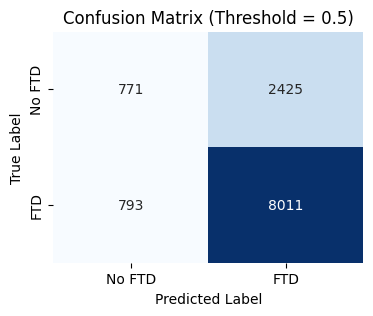

In [28]:
# Convert probabilities to binary predictions using 0.5 threshold
y_pred = (valid_pred >= 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(valid_leads['label_ftd'], y_pred)
tn, fp, fn, tp = cm.ravel()

# Plot confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No FTD', 'FTD'],
            yticklabels=['No FTD', 'FTD'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Threshold = 0.5)')
plt.show()

#### Explaining the Metrics

Since we use the predicted probability $P_{FTD}$ for ranking, not just a binary prediction, the ROC-AUC and Average Precision metrics are most relevant:

- **ROC-AUC**: Evaluates the model's overall discriminatory power.
- **Average Precision (AP)**: The ideal metric for this task, as it rewards models that successfully prioritize the most valuable leads (FTDs) at the top of the predicted score list.


In [29]:
# Feature importance extraction (top features)
# We extract transformer feature names for readability
ohe = clf.named_steps['pre'].named_transformers_['ohe']
cat_feature_names = ohe.get_feature_names_out(cat_cols)
remainder_names = num_cols
feature_names = list(cat_feature_names) + remainder_names
importances = clf.named_steps['rfc'].feature_importances_
feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False).head(25)
feat_imp.reset_index(drop=True, inplace=True)
feat_imp

,feature,importance
0,hour,0.124321
1,affiliate_quality,0.070603
2,brand_baseline_cr,0.053425
3,brand_baseline_ftd,0.048857
4,vertical_focus_Casino,0.023106
5,device_desktop,0.022896
6,device_android,0.021017
7,device_ios,0.015422
8,vertical_focus_Sports,0.013182
9,geo_NZ,0.012798


## 5) Blend SVD + Propensity → Contextual Ranking (Expected EPC) 💰

This is the final, value-generating step. We combine the strengths of both models:

1. **SVD Score:** Long-term historical affinity/relevance (Collaborative Filtering).
2. **$P_{FTD}$:** Short-term, contextual conversion probability (Propensity Model).
3. **Payout Structure:** Brand's economic terms (CPA/RevShare/Hybrid).
    
    **The output is a single Blended Score that maximizes Expected EPC.**


In [30]:
# Add synthetic economics for brands if not present
# Since we don’t have actual commercial deal terms, we add synthetic Cost per acquisition (CPA) payouts and RevShare percentages. 
# These let us translate conversion probability into expected revenue per click (EPC), which is the real business KPI.

if 'cpa_eur' not in brands.columns:
    rng2 = np.random.default_rng(1234)
    brands['cpa_eur'] = np.clip(rng2.normal(160, 35, len(brands)), 60, 350)
if 'revshare_pct' not in brands.columns:
    rng2 = np.random.default_rng(4321)
    brands['revshare_pct'] = np.clip(rng2.normal(0.30, 0.05, len(brands)), 0.15, 0.5)

`cpa_eur` and `revshare_pct` are crucial as they translate a successful event (FTD) into monetary value.

- `cpa_eur`: Cost Per Acquisition payout for an FTD.
- `revshare_pct`: Percentage of Net Gaming Revenue (NGR) shared with the affiliate.


In [31]:
# expected epc function
def expected_epc(p_ftd, brand_row):
    '''
    This function combines:
    - The predicted FTD probability (p_ftd) from the classifier,
    - The payout mechanics of the brand (CPA, RevShare, or Hybrid), to estimate expected EPC.
    This way, recommendations are tied to actual commercial impact, not just probability of conversion.
    '''
    if brand_row['payout_type']=='CPA':
        return p_ftd * brand_row['cpa_eur']
    elif brand_row['payout_type']=='RevShare':
        return p_ftd * brand_row['revshare_pct'] * brand_row['avg_ftd_value']
    else:
        # Hybrid: half CPA, half RevShare
        cpa = p_ftd * brand_row['cpa_eur'] * 0.5
        rs  = p_ftd * brand_row['revshare_pct'] * brand_row['avg_ftd_value'] * 0.5
        return cpa + rs

### **EPC Calculation: The Link to Revenue**

This function is critical: it converts a statistical prediction ($P_{FTD}$) into a quantifiable monetary expectation (**Expected EPC**).

$$ \text{Expected EPC} = P_{FTD} \times \text{Payout Value} \times \text{Click-to-Reg Rate} $$ 

*(Note: In this specific implementation, we assume a constant Click-to-Reg rate for simplicity, making $\text{Expected EPC} \approx P_{FTD} \times \text{Payout Value}$)*

**EPC is the ultimate business KPI for ranking offers.** A brand with a slightly lower conversion chance but a much higher CPA/RevShare value will be ranked higher, driving maximum ROI.


In [32]:
# recommend_offers (uses recon and clf trained earlier)

# This simulates a real-time scenario:
# for example “Affiliate 123 is sending us traffic from Germany, on mobile, at 8pm — what should we recommend them?”

def recommend_offers(affiliate_id:int, geo:str, device:str, top_k:int=5, hour:int=20):
    # SVD part: if affiliate not in training set, we fallback to average scores
    # “This step answers: Which brands are historically similar affiliates most likely to convert with?”
    try:
        ai = aff_index[affiliate_id]
        svd_scores = pd.Series(recon[ai], index=[brand_index_inv[i] for i in range(recon.shape[1])]) # predicted brand affinity
    except KeyError:
        # new affiliate: use mean score per brand
        svd_scores = pd.Series(recon.mean(axis=0), index=[brand_index_inv[i] for i in range(recon.shape[1])])

    # Build context for each brand
    # Build a row for every brand with the context (affiliate features, geo, device, hour).
    # Pass this through the FTD classifier to predict p(FTD) for each brand in this specific context
    aff_row = affiliates[affiliates['affiliate_id']==affiliate_id].iloc[0]
    ctx = pd.DataFrame({
        'affiliate_id': [affiliate_id]*len(brands),
        'brand_id': brands['brand_id'],
        'geo': [geo]*len(brands),
        'device': [device]*len(brands),
        'traffic_source': [aff_row['traffic_source']]*len(brands),
        'vertical_focus': [aff_row['vertical_focus']]*len(brands),
        'hour': [hour]*len(brands),
        'affiliate_quality': [aff_row['avg_quality']]*len(brands),
        'brand_baseline_cr': brands['baseline_cr'],
        'brand_baseline_ftd': brands['baseline_ftd']
    })

    p = clf.predict_proba(ctx[['geo','device','traffic_source','vertical_focus','brand_id','affiliate_id','hour','affiliate_quality','brand_baseline_cr','brand_baseline_ftd']])[:,1]
    # “Here we personalize predictions for this affiliate, right now — not just historically. This accounts for things like traffic coming from Germany or peak conversion hours.”

    df = brands.copy()
    df['svd_score'] = df['brand_id'].map(lambda b: svd_scores.get(b, 0.0))
    
    # For each brand, compute expected EPC.
    # This allows ranking brands by monetary value, not just probability.
    # “This step ties machine learning predictions to what really matters — revenue. 
    # It ensures we recommend the most profitable offers, not just the most likely to convert.”
    df['p_ftd'] = p
    df['epc'] = [expected_epc(p_i, row) for p_i, (_,row) in zip(p, df.iterrows())]
    
    # enforce geo allow list (compliance)
    df['allowed'] = df['allowed_geos'].apply(lambda allowed: geo in allowed)
    df = df[df['allowed']].copy()

    ### Normalize ###
    # Normalize both signals.
    # Blend them into one ranking score:
    # 40% weight to collaborative filtering affinity (historic patterns).
    # 60% weight to contextual EPC (short-term economics).
    # This balance ensures recommendations are both relevant (affinity) and profitable (EPC).
    # “We strike a balance: recommendations are guided by both what affiliates historically like and what is profitable right now. 
    # We put a bit more emphasis on profitability (60%) to maximize ROI.”
    
    df['svd_norm'] = (df['svd_score'] - df['svd_score'].min())/(df['svd_score'].max() - df['svd_score'].min() + 1e-9)
    df['epc_norm'] = (df['epc'] - df['epc'].min())/(df['epc'].max() - df['epc'].min() + 1e-9)
    df['blended_score'] = 0.4*df['svd_norm'] + 0.6*df['epc_norm']
    
    ### Rank and Return
    df = df.sort_values('blended_score', ascending=False)
    df['reason'] = df.apply(lambda r: f"{r['payout_type']} • est EPC €{r['epc']:.2f} • vertical {r['vertical']}", axis=1)
    return df[['brand_id','brand_name','reason','p_ftd','epc','svd_score','blended_score']].head(top_k)

In [33]:
# Demo: show recommendations for a few affiliates
sample_affiliates = list(affiliates['affiliate_id'].sample(3, random_state=RANDOM_STATE))
for aid in sample_affiliates:
    print('\nAffiliate', aid)
    display(recommend_offers(aid, geo='DE', device='android', top_k=6))


Affiliate 96


,brand_id,brand_name,reason,p_ftd,epc,svd_score,blended_score
5,6,Brand_06,CPA • est EPC €252.16 • vertical Casino,0.962607,252.162981,47.807734,1.000000
16,17,Brand_17,CPA • est EPC €135.37 • vertical Casino,0.772607,135.372815,28.575877,0.531102
49,50,Brand_50,CPA • est EPC €184.08 • vertical Sports,0.875338,184.082121,12.293660,0.512848
27,28,Brand_28,CPA • est EPC €141.04 • vertical Sports,0.878938,141.035658,23.564805,0.501547
6,7,Brand_07,RevShare • est EPC €40.24 • vertical Bingo,0.927607,40.243576,43.021849,0.414081
35,36,Brand_36,CPA • est EPC €131.29 • vertical Casino,0.922607,131.293558,12.123348,0.375887



Affiliate 16


,brand_id,brand_name,reason,p_ftd,epc,svd_score,blended_score
27,28,Brand_28,CPA • est EPC €129.97 • vertical Sports,0.810,129.973698,60.829558,0.829587
5,6,Brand_06,CPA • est EPC €167.65 • vertical Casino,0.640,167.653423,38.293478,0.819537
49,50,Brand_50,CPA • est EPC €175.60 • vertical Sports,0.835,175.599011,13.031658,0.680191
16,17,Brand_17,CPA • est EPC €120.90 • vertical Casino,0.690,120.898825,14.943277,0.488673
22,23,Brand_23,CPA • est EPC €143.20 • vertical Casino,0.710,143.203110,1.046529,0.478999
26,27,Brand_27,CPA • est EPC €125.50 • vertical Sports,0.790,125.503723,4.892598,0.438625



Affiliate 31


,brand_id,brand_name,reason,p_ftd,epc,svd_score,blended_score
5,6,Brand_06,CPA • est EPC €243.62 • vertical Casino,0.930,243.621380,29.579886,0.826410
16,17,Brand_17,CPA • est EPC €160.32 • vertical Casino,0.915,160.322355,26.343986,0.574029
3,4,Brand_04,RevShare • est EPC €64.76 • vertical Casino,0.895,64.756109,49.672254,0.518101
35,36,Brand_36,CPA • est EPC €133.77 • vertical Casino,0.940,133.768750,26.628627,0.504947
27,28,Brand_28,CPA • est EPC €114.73 • vertical Sports,0.715,114.729869,31.954737,0.499668
22,23,Brand_23,CPA • est EPC €178.50 • vertical Casino,0.885,178.499651,3.469246,0.425374


## 6) Next Steps & Deployment Notes 🚀

The demonstrated model is a robust foundation for a production-ready system. Key next steps for deployment and optimization include:

- **Data Source Integration:** Replace synthetic lead-generation with real lead/session logs for true-to-life training and real-time inference.
- **Feature Store:** Implement a feature store (or precompute features daily) to ensure low-latency scoring for real-time traffic requests.
- **Serving Layer:** Serve the SVD affinity matrix and propensity model via a lightweight API (e.g., FastAPI, Flask) to allow for daily top-N generation for Affiliates and real-time re-ranking on click/session start.
- **Monitoring & A/B Testing:** Add monitoring for model drift and calibration. Most importantly, validate the system's business impact through a rigorous **A/B test** against the current ranking system, tracking the **lift in EPC / FTD rate**.
